In [310]:
import numpy as np
import pandas as pd
import seaborn as sns
from sargas import *
import tqdm
import matplotlib.pyplot as plt
from multiprocessing import Pool
import glob
import re
from collections import namedtuple
from scipy.stats import gamma, maxwell, norm

import warnings
warnings.filterwarnings('ignore')

PATTERN = re.compile("(\d+.\d+)_t_(\d+.\d+)_rho.gro")

sns.set_palette("Dark2")
sns.set_style("ticks")
sns.set_context("talk")

In [2]:
State = namedtuple("State", ["nparticles", "temperature", "density"])
SimulationParameters = namedtuple("SimulationParameters", ["dt", "nequilibration", "nproduction"], defaults=(0.005, 10_000, 100_000))
SamplingParameters = namedtuple("SamplingParameters", ["nsample", "ntrajectory", "filename"], defaults=(100, 1_000, "trajectory.gro"))

def nvt_vv(state, rc, thermostat, thermostat_frequency=None, simulation_parameters=SimulationParameters(), sampling_parameters=SamplingParameters()):
    integrator = Integrator.velocity_verlet(simulation_parameters.dt)
    return nvt(state, rc, integrator, thermostat, thermostat_frequency, simulation_parameters, sampling_parameters)

def nvt_langevin(state, rc, friction_coefficient, simulation_parameters=SimulationParameters(), sampling_parameters=SamplingParameters()):
    integrator = Integrator.langevin(simulation_parameters.dt, state.temperature, friction_coefficient)
    return nvt(state, rc, integrator, simulation_parameters=simulation_parameters, sampling_parameters=sampling_parameters)

def nvt(state, rc, integrator, thermostat=None, thermostat_frequency=None, simulation_parameters=SimulationParameters(), sampling_parameters=SamplingParameters()):
    potential = Potential.lennard_jones(1.0, 1.0, rc, True, shift_at=rc)
    configuration = Configuration.lattice(state.nparticles, state.density, initial_temperature=state.temperature)
    system = System(configuration, potential)
    propagator = MolecularDynamics(integrator, thermostat)
    simulation = Simulation.molecular_dynamics(system, propagator, thermostat_frequency=thermostat_frequency)

    # Equilibration
    eq_steps = simulation_parameters.nequilibration // 100
    for _ in tqdm.tqdm(range(100), desc="Equilibration"):
        simulation.run(eq_steps)
    
    # Add sampler
    props = Sampler.properties(sampling_parameters.nsample)
    trj = Sampler.trajectory(sampling_parameters.filename, sampling_parameters.ntrajectory)
    simulation.add_sampler(props)
    simulation.add_sampler(trj)
    # Production
    prod_steps = simulation_parameters.nproduction // 100
    for _ in tqdm.tqdm(range(100), desc="Production   "):
        simulation.run(prod_steps)
    
    data = pd.DataFrame(props.data)
    data["time"] = simulation_parameters.dt * data.index * sampling_parameters.nsample
    return data

# Assignment 4: Molecular Dynamics in the Canonical Ensemble

## Introduction <a id="Introduction"/>

In our Monte-Carlo simulations we generated a canonical ensemble - the natural ensemble for Monte-Carlo simulations.
For molecular dynamics the natural ensemble is the microcanonical ($NVE$) ensemble.
There are generally two ways to generate an $NVT$ ensemble during a MD simulation:

1. in addition to the integration method add an algorithm that changes the velocities so that the desired temperature is generated, or
2. use an integration method that directly generates an $NVT$ ensemble.

In this assignment you will implement a simple algorithm that is used in conjunction with the integration algorithm from the last assignment.
This so-called **thermostat** modifies the velocities after each integration step.

## Table of Contents <a id="toc"/>

- [Introduction](#Introduction)
- [Compiling](#compiling-And-Testing)
- [Simulation Details](#Simulation-Details)
- [Velocity-Verlet Integrator](#Velocity-Verlet)
- [Your Tasks](#tasks)

## Compiling <a id="compiling-And-Testing"/>

[↑ back to top](#toc)

**There are no tests in this assignment.**

To **compile** the code (*which does not build the python module*), use 

```
RUSTFLAGS="-C target-cpu=native" cargo build --release
```

To build the **Python module**, type

```
RUSTFLAGS="-C target-cpu=native" maturin develop --release
```

If the last step fails stating that "the resource is currently in use" (or something similar) make sure to **stop the Jupyter kernel** and try running the command again.

## Distributions of Velocity, Speed and the Kinetic Energy <a id="Distributions"/>

[↑ back to top](#toc)

The components of the velocity (vectorial) of a particle follow a Gaussian distribution with mean of zero and a standard deviation of $\sigma = \sqrt{mkT}$. The probability density *of each velocity component* reads

\begin{equation}
    \textbf{Gaussian distribution: }p(v_{\alpha}) = \sqrt{\frac{m\beta}{2\pi}} \exp \left[-\frac{1}{2} \beta m v_{\alpha}^2\right], ~ \alpha \in [x, y, z]
\end{equation}

To get the normalized probability density of the *speed*, i.e. the *length of the velocity vector*, $p(v)$, we can utilize that the integral of a normalized probability density must be unity.
Therefore, we can equate the integral of the (yet unknown) probability density with the integral over the known probability density of the velocity.

\begin{align}
    \int_0^\infty p(v)\mathrm{d}v &\overset{!}{=} 1 \overset{!}{=} \left(\frac{\beta m}{2\pi} \right)^{3/2} \iiint_{-\infty}^\infty \exp \left[-\frac{1}{2} \beta m|\mathbf{v'}|^2\right] \mathrm{d}\mathbf{v'} \\
\end{align}

We now can perform a coordinate transformation to spherical coordinates, motivated by the fact that the speed (length of the velocity vector) $|\mathbf{v}| = v$ is a natural variable in spherical coordinates. 

\begin{align}
    \int p(v)\mathrm{d}v &= \left(\frac{\beta m}{2\pi} \right)^{3/2} \iiint \exp \left[-\frac{1}{2} \beta mv'^2\right] v'^2 \sin{\theta}\mathrm{d}\varphi\mathrm{d}\theta\mathrm{d}v' \\
    \int p(v)\mathrm{d}v &= 4\pi\left(\frac{\beta m}{2\pi} \right)^{3/2} \int \exp \left[-\frac{1}{2} \beta mv'^2\right] v'^2 \mathrm{d}v'
\end{align}

Both integrals now have the same integration variable. We can identify for $p(v)$:

\begin{equation}
    \textbf{Maxwell-Boltzmann distribution: }p(v) = 4\pi\left(\frac{\beta m}{2\pi} \right)^{3/2} v^2 \exp \left[-\frac{1}{2} \beta mv^2\right] 
\end{equation}

The kinetic energy of the system follows a Gamma distribution:

\begin{align}
    \textbf{Gamma distribution: }p(E) = \Gamma(3N/2, k_BT)
\end{align}

## The Andersen Thermostat <a id="Simulation-Details"/>

[↑ back to top](#toc)

The Andersen thermostat selects a particle and brings it into contact with a *heat bath* which means a new velocity according to a Maxwell-Boltzmann distribution is applied.
The probability of a bath collision of a particle in the time intervall $[t, t + \Delta t]$ (Poisson distribution) is given by:

\begin{equation}
    p(t; \nu) = \nu e^{-\nu t}
\end{equation}

where $\nu$ is the *collision frequency*.

The algorithm works as follows:
 
1. After the integration step, the thermostat function is called. (already implemented)
2. For each particle:
    1. Test if the particle undergoes collision with bath. (accept if $X < \nu \Delta t^*$, where $X$ is a uniformly distributed random number between 0 and 1) 
    2. if it does: apply a new velocity vector
    3. if it does not: do nothing.

---
## Your Tasks <a id="tasks"/>

[↑ back to top](#toc)

### 1. Implement the Andersen Thermostat.

1. In `src/propagator/molecular_dynamics/andersen.rs` implement the algorithm that assigns particles a new random position according to a collision frequency.
2. Run simulations for different collision frequencies and plot the temperature versus simulation time.
3. Generate three plots:
    1. Distribution of **velocity components** from simulation vs Gaussian distribution
    2. Distribution of **norm of velocity vectors** from simulation vs Maxwell-Boltzmann distribution
    3. Distribution of **kinetic energy** from simulation vs Gamma-Distribution

In [279]:
nparticles = 256
rc = 2.5
density = 0.8442
dt = 0.005
temperature = 2.0
collision_frequency =

lennard_jones = Potential.lennard_jones(1.0, 1.0, rc, True, shift_at=rc) # truncated & shifted with long-range corrections
configuration = Configuration.lattice(nparticles, density, initial_temperature=temperature)
system = System(configuration, lennard_jones)

# Build the propagator
integrator = Integrator.velocity_verlet(dt)
thermostat = Thermostat.andersen(temperature, dt, collision_frequency)
propagator = MolecularDynamics(integrator, thermostat)

# Build the simulation
simulation = Simulation.molecular_dynamics(system, propagator, thermostat_frequency=1)

# Add Sampler for properties and run simulation...
props = Sampler.properties(100)
simulation.add_sampler(props)

In [314]:
# Run your simulations and generate plots to figure out a good value for the collision frequency eta

In [305]:
# This cell can be used to gather information about the velocity vectors during a simulation.
# Use this cell to check the distributions.
velocities = []
for _ in tqdm.tqdm(range(100)):
    simulation.run(1000)
    velocities.append(system.velocities)
    
velocities = np.concatenate(velocities) # contains the velocity components (vx, vy, vz) for 100 snapshots
data = pd.DataFrame(props.data)

100%|██████████| 100/100 [00:09<00:00, 10.71it/s]


#### Velocity Components: Gaussian Distribution

Use `norm.pdf` (already imported) to generate/plot the **p**robability **d**ensity **f**unction for a Gaussian distribution.
Read the documentation to figure out what to use for the `scale` parameter.

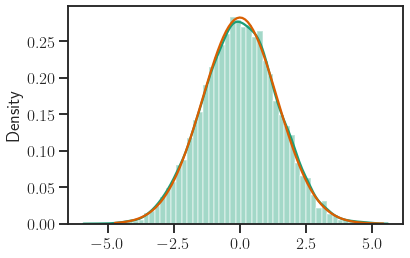

In [311]:
sns.distplot(x=velocities[:, 0])
xs = np.linspace(velocities[:, 0].min()*0.9, velocities[:, 0].max()*1.1, 100) 
sns.lineplot(xs, norm.pdf(xs, scale=np.sqrt(temperature)));

#### Speed: Maxwell-Boltzmann Distribution

Use `maxwell.pdf` (already imported) to generate/plot the **p**robability **d**ensity **f**unction for a Maxwell-Boltzmann distribution.
Read the documentation to figure out what to use for the `scale` parameter.

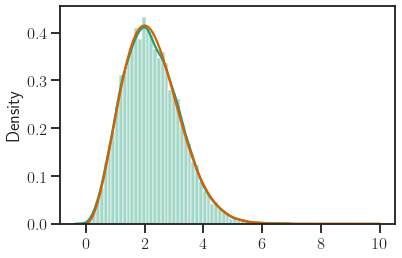

In [312]:
xs = np.linspace(0, 10, 100) 
sns.distplot(x=np.linalg.norm(velocities, axis=1))
sns.lineplot(xs, maxwell.pdf(xs, scale=np.sqrt(temperature)));

#### Kinetic Energy: Gamma Distribution

Already implemented for you!

<AxesSubplot:ylabel='Density'>

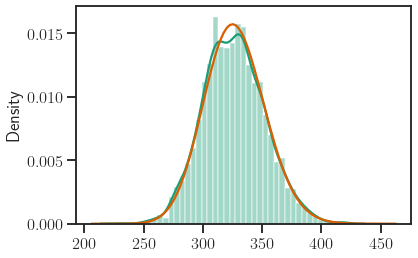

In [313]:
sns.distplot(data.kinetic_energy.values)
xs = np.linspace(0.9*data.kinetic_energy.min(), 1.1*data.kinetic_energy.max(), 100)
sns.lineplot(xs, gamma.pdf(xs, a=3/2*nparticles, loc=data.kinetic_energy.mean()/nparticles, scale=temperature))

### 2. Ensemble Validation

#### Reference

> Merz PT, Shirts MR (2018) Testing for physical validity in molecular simulations. PLoS ONE 13(9): e0202764. https://doi.org/10.1371/journal.pone.0202764  
> Shirts, "M. R. Simple Quantitative Tests to Validate Sampling from Thermodynamic Ensembles", J. Chem. Theory Comput., 2013, 9 (2), pp 909–926, http://dx.doi.org/10.1021/ct300688p

#### Theory

The probability density in the canonical ensemble reads

\begin{align}
    P(\bar{x} | \beta) \propto e^{-\beta {\cal H}(\bar{p}, \bar{q})} \,,
\end{align}

where $\bar{x} = (\bar{p}, \bar{q}, \bar{N}, V)$ denotes a microstate.
The probability of observing a specific energy $E$ in the canonical ensemble is:

\begin{align}
P(E | \beta) &= \frac{\Omega(E)}{Q(\beta)} e^{-\beta E} \,,
\end{align}

with the canonical partition function
\begin{align}
Q(\beta) &= \int \Omega(E') e^{-\beta E'} \mathrm{d}E'
\end{align}

For a given $\bar{N}, V$, the micro canonical partition function is a function of only the energy while the canonical partition function is a function of only the temperature.
Consider two simulations at different (inverse) temperatures, $\beta_1$ and $\beta_2$, in which we observe common energies, $E$, in both simulations.
Since the micro canonical partition function is a function of only the energy, for an energy that is observed in both simulations, the micro canonical probability must be the same for both simulations.

Thus, we can write:

\begin{align}
P(E | \beta_1) Q(\beta_1) e^{\beta_1 E} = P(E | \beta_2) Q(\beta_2) e^{\beta_2 E}
\end{align}

solving for the ratio of probabilities:

\begin{align}
\frac{P(E | \beta_2)}{P(E | \beta_1)} &= \frac{Q(\beta_1)}{Q(\beta_2)} \frac{e^{-\beta_2 E}}{e^{-\beta_1 E}} \,,
\end{align}

which we can rewrite, taking the logarithm and using $Q(\beta) = e^{-\beta A}$,

\begin{align}
\ln \left[\frac{P(E | \beta_2)}{P(E | \beta_1)} \right] &= \color{blue}{(\beta_2 A_2 - \beta_1 A_1)} \color{red}{-(\beta_2 - \beta_1)} E\,, \\
&= \color{blue}{a_0} + \color{red}{a_1} E
\end{align}

The lefthand side of the last equation can be determined from simulations by creating histograms from time series of energies. When plotted versus the energy, the resulting graph has to be a line with slope $a_1$ which is simply the negative difference of the inverse temperatures, which is known.

#### Perform an Ensemble Validation Check

Use the following two states:
- $T^*_1 = 1.109$
- $T^*_2 = 1.145$

Equal for both states:
- $\Delta t^* = 0.01$
- $N = 300$
- $\rho^* = 0.2686$
- $r_c = 2.5$

**Tasks:**
- Perform an ensemble validation using your implemented Andersen thermostat.
- Use the helper functions (defined at start of this notebook)

**Optional:**
- Perform an ensemble validation using the Berendsen thermostat. (`tau = 1.25`)

In [ ]:
simulation_parameters = SimulationParameters(#your input here)

# set up state 1 using the `State` namedtuple
s1 = State(#your input here)
s2 = State(#your input here)

sim1 = nvt_vv(#your input here)
sim2 = nvt_vv(#your input here)

Run the following cells and try to understand what happens.

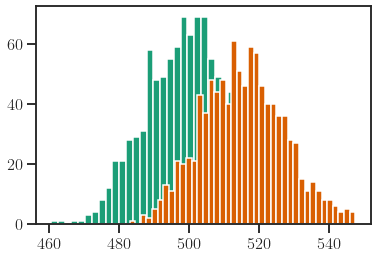

In [273]:
_ = plt.hist(sim1.kinetic_energy, bins=40)
_ = plt.hist(sim2.kinetic_energy, bins=40)

In [274]:
rng = max(sim1.kinetic_energy.min(), sim2.kinetic_energy.min()), min(sim1.kinetic_energy.max(), sim2.kinetic_energy.max())

In [275]:
bins = 10
h1, edges = np.histogram(sim1.kinetic_energy, bins=bins, range=rng)#, normed=True)
h2, _ = np.histogram(sim2.kinetic_energy, bins=bins, range=rng)#, normed=True)
centers = 0.5*(edges[1:]+ edges[:-1])

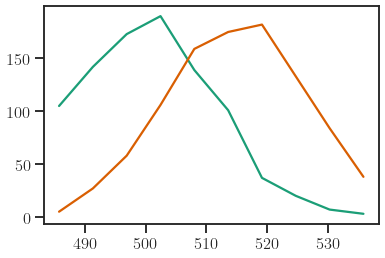

In [276]:
plt.plot(centers, h1)
plt.plot(centers, h2)

In [277]:
var = 1 / h1 - 1 / np.sum(h1) + 1 / h2 - 1 / np.sum(h2)
m, b = np.polyfit(centers, np.log(h2 / h1), 1, w=1 / np.sqrt(var))
slope = -(1.0 / s2.temperature - 1.0 / s1.temperature)
shift = (m - slope) * centers[len(centers) // 2] + b

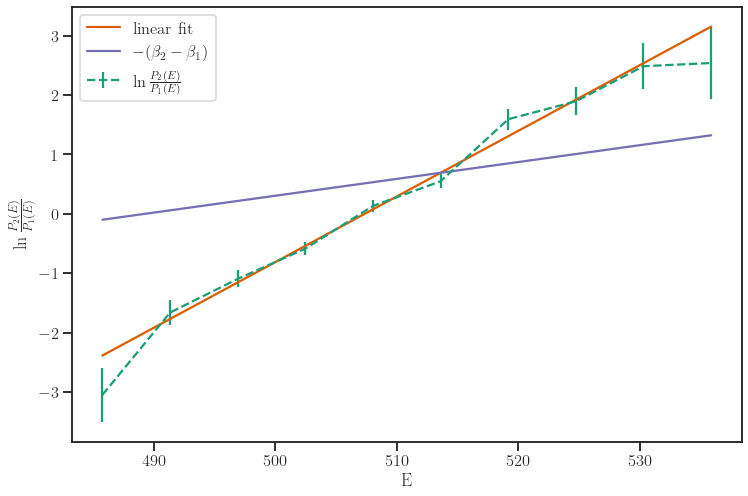

In [278]:
plt.figure(figsize=(12, 8))
plt.errorbar(centers, np.log(h2 / h1), yerr=np.sqrt(var), fmt='--', label=r'$\ln\frac{P_2(E)}{P_1(E)}$')
plt.plot(centers, m * centers + b, label='linear fit')
plt.plot(centers, slope * centers + shift, label=r'$-(\beta_2 - \beta_1)$')
plt.xlabel("E")
plt.ylabel(r'$\ln\frac{P_2(E)}{P_1(E)}$')
plt.legend();